In [7]:
from load import wds_load
from streamlined_example import MyCustomDataset, Thing, fix_borders, report_borders, report_duration
import pytorch_lightning as pl
import warnings
warnings.filterwarnings("ignore")

module = Thing.load_from_checkpoint("clean-start-ce.ckpt", strict=False)
trainer = pl.Trainer(accelerator='gpu', devices=[1])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [8]:
limit = 8
split = "train"
file_path = f"{split}_data_0.03wl_0.015ws.tar.xz"
files = wds_load(file_path, limit)

0it [00:00, ?it/s]

In [9]:
dataset = MyCustomDataset(files)
generated = sum(trainer.predict(module.with_weights, dataloaders=dataset.batch(32, shuffle=False)), start=[])
generated, items = generated[0]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

In [10]:
# generated[0].sum(axis=1, keepdims=True).T

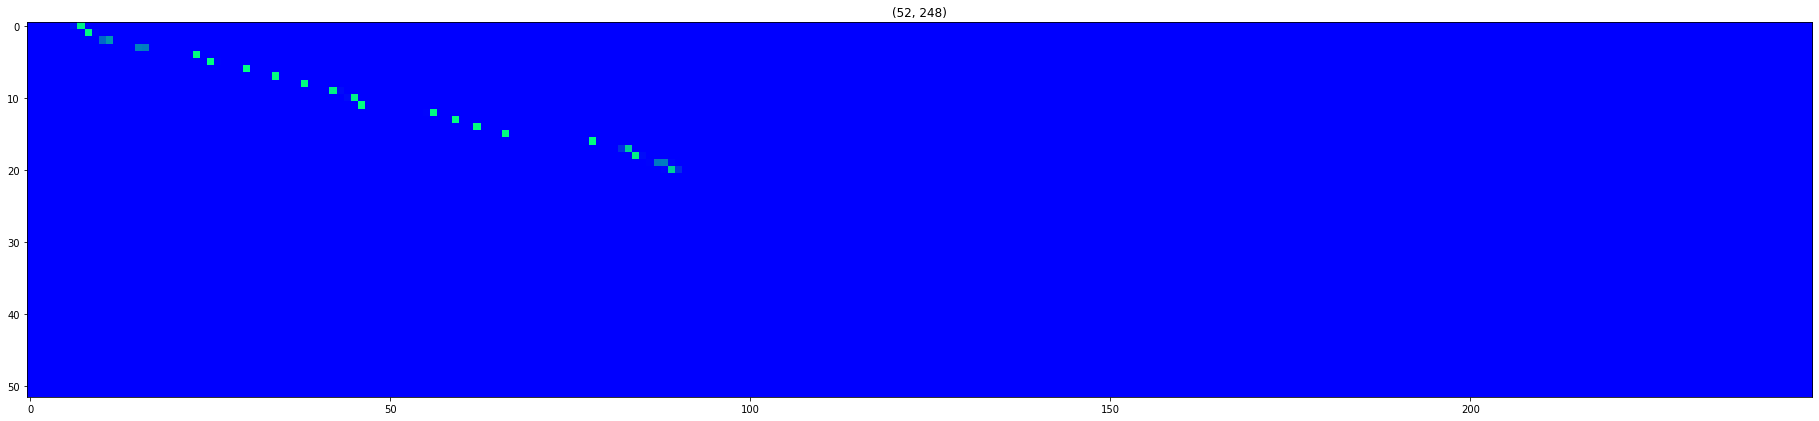


 torch.Size([1, 20, 248]) torch.Size([1, 20, 6])
tensor(-0.7667)
tensor(1.) torch.Size([1, 20])


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0



 torch.Size([1, 20, 248]) torch.Size([1, 20, 6])
tensor(-0.2371)
tensor(1.0850) torch.Size([1, 20])


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.2,1.2,1.1,1.1,1.0,1.0,1.0,1.0,1.2,1.0,1.0,1.0,1.2,1.2,1.2,1.0,1.0,1.0,1.2,1.1


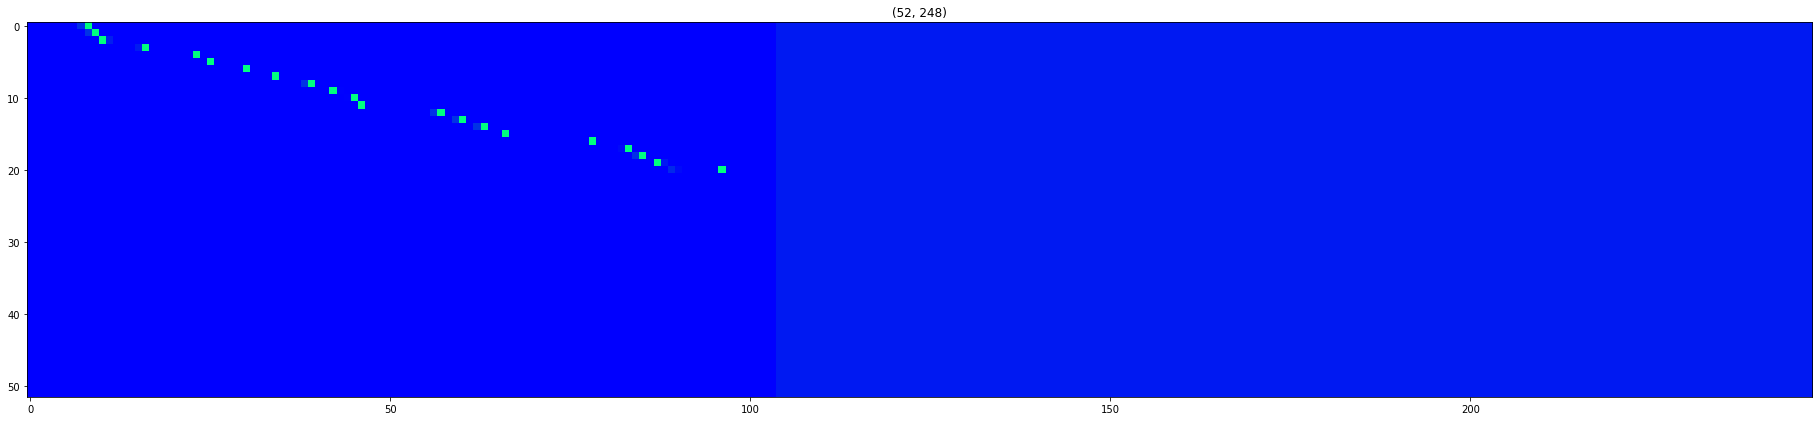

In [16]:
import matplotlib.pyplot as plt
import torch
from IPython.display import display
import pandas as pd


def show_tensor(aTensor, index=1, figsize=(32, 32), hide_x=False, labels=None, cmap=None, fig=True):
    if len(aTensor.shape) > 2:
        aTensor = aTensor[index]

    if hasattr(aTensor, 'detach'): aTensor = aTensor.detach()
    if hasattr(aTensor, 'cpu'): aTensor = aTensor.cpu()
    if hasattr(aTensor, 'numpy'): aTensor = aTensor.numpy()

    fig and plt.figure(figsize=figsize)
    plt.title(str(aTensor.shape))
    plt.imshow(aTensor, cmap='winter')
    plt.clim(0, 1)
    plt.show()


def calculate(att: torch.FloatTensor, target: torch.FloatTensor):
    arr = att[:target.shape[0]].unsqueeze(0)
    delta = target - target.clone().to(torch.long)
    target = target.unsqueeze(1).unsqueeze(0).to(torch.long)
    # target = torch.dstack([target - 1, target, target + 1])
    target = torch.dstack([target - 2, target - 1, target, target + 1, target + 2, target + 3])
    print("\n", arr.shape, target.shape)

    result = torch.take_along_dim(arr, target, 2)
    gradient = torch.FloatTensor([1, 2, 3, 4, 5, 6])
    diff = (result * gradient).sum(axis=-1) - (delta + 3)
    print(diff.mean())
    result = result.sum(axis=-1)

    calc = result.round(decimals=1)
    print(calc.mean(), calc.shape)
    display(pd.DataFrame(calc.squeeze(0)).T)
    return result

index = -1
item = items[index]
gen = torch.FloatTensor(generated[index].copy()).unsqueeze(0)
show_tensor(gen[0])
target = torch.FloatTensor(item.target_timestamps[:-1])
calc = calculate(gen[0], target).round(decimals=1)

gen /= 5
gen[0, :, item.features_spectogram.shape[0]:] = 0.1

for i, b in enumerate(item.target_timestamps):
    gen[0, i, int(b)] = 1

calc = calculate(gen[0], target).round(decimals=1)
show_tensor(gen[0])


In [161]:
torch.log(torch.FloatTensor([0, 0.5, 1.0, 1.5]).clip(0.0001, 0.9999)).round(decimals=2)

tensor([-9.2100, -0.6900, -0.0000, -0.0000])

In [150]:
f = torch.nn.Softmax(dim=0)
arr = torch.FloatTensor([(i % 4) * 2  for i in range(10)])

for i in range(30):
    print()
    print(arr.round(decimals=1))
    print(f(arr).round(decimals=2))
    arr.requires_grad = True
    arr.retain_grad()

    loss = f(arr)[2]
    print(loss)
    loss.backward()
    arr.grad.round(decimals=2)

    arr = arr.grad + arr.detach()
    arr = arr.detach().clone()


tensor([0., 2., 4., 6., 0., 2., 4., 6., 0., 2.])
tensor([0.0000, 0.0100, 0.0600, 0.4300, 0.0000, 0.0100, 0.0600, 0.4300, 0.0000,
        0.0100])
tensor(0.0580, grad_fn=<SelectBackward0>)

tensor([-0.0000, 2.0000, 4.1000, 6.0000, -0.0000, 2.0000, 4.0000, 6.0000, -0.0000,
        2.0000])
tensor([0.0000, 0.0100, 0.0600, 0.4300, 0.0000, 0.0100, 0.0600, 0.4300, 0.0000,
        0.0100])
tensor(0.0624, grad_fn=<SelectBackward0>)

tensor([-0.0000, 2.0000, 4.1000, 5.9000, -0.0000, 2.0000, 4.0000, 5.9000, -0.0000,
        2.0000])
tensor([0.0000, 0.0100, 0.0700, 0.4200, 0.0000, 0.0100, 0.0600, 0.4200, 0.0000,
        0.0100])
tensor(0.0674, grad_fn=<SelectBackward0>)

tensor([-0.0000, 2.0000, 4.2000, 5.9000, -0.0000, 2.0000, 4.0000, 5.9000, -0.0000,
        2.0000])
tensor([0.0000, 0.0100, 0.0700, 0.4200, 0.0000, 0.0100, 0.0600, 0.4200, 0.0000,
        0.0100])
tensor(0.0732, grad_fn=<SelectBackward0>)

tensor([-0.0000, 2.0000, 4.2000, 5.9000, -0.0000, 2.0000, 4.0000, 5.9000, -0.0000,
       

In [138]:
import torch

criteria = torch.nn.MSELoss()
f = torch.nn.Softmax(dim=0)
cross = torch.nn.CrossEntropyLoss(ignore_index=-100)

count = 15
index = 5
gradient = torch.FloatTensor(range(count))

arr = torch.FloatTensor([0 + 0.1 * i for i in range(count)])
# arr[-1] = 0
# arr[1] = -90
arr[index] = 2

arr.requires_grad = True
arr.retain_grad()

# pred = (f(arr) * gradient).sum().unsqueeze(0)
# pred.retain_grad()
#
# target = torch.FloatTensor([index])
# print(pred, pred.shape, target.shape)
# loss = criteria(pred, target)

# print(arr.shape, torch.LongTensor([index]).shape)
loss = cross(arr.unsqueeze(0), torch.LongTensor([index]))
loss.backward()
print(loss)

torch.stack([arr, f(arr), gradient, f(arr) * gradient, arr.grad.abs()]).detach().numpy().round(3)

tensor(1.6596, grad_fn=<NllLossBackward0>)


array([[ 0.   ,  0.1  ,  0.2  ,  0.3  ,  0.4  ,  2.   ,  0.6  ,  0.7  ,
         0.8  ,  0.9  ,  1.   ,  1.1  ,  1.2  ,  1.3  ,  1.4  ],
       [ 0.026,  0.028,  0.031,  0.035,  0.038,  0.19 ,  0.047,  0.052,
         0.057,  0.063,  0.07 ,  0.077,  0.085,  0.094,  0.104],
       [ 0.   ,  1.   ,  2.   ,  3.   ,  4.   ,  5.   ,  6.   ,  7.   ,
         8.   ,  9.   , 10.   , 11.   , 12.   , 13.   , 14.   ],
       [ 0.   ,  0.028,  0.063,  0.104,  0.154,  0.951,  0.281,  0.363,
         0.458,  0.57 ,  0.7  ,  0.851,  1.026,  1.228,  1.462],
       [ 0.026,  0.028,  0.031,  0.035,  0.038,  0.81 ,  0.047,  0.052,
         0.057,  0.063,  0.07 ,  0.077,  0.085,  0.094,  0.104]],
      dtype=float32)

In [34]:
cross(arr.unsqueeze(0),torch.LongTensor([24]))

tensor(0., grad_fn=<NllLossBackward0>)

In [238]:
mask_transcription = torch.load('mask_transcription.pt')#  * 1.0
mask_audio = torch.load('mask_audio.pt')# * 1.0
w = torch.load('w.pt')
# w += torch.rand_like(w) * 0.1

w = w * mask_audio.unsqueeze(1) * mask_transcription.unsqueeze(2)
print(mask_audio.shape)
w = torch.sub(w, ((~mask_audio) * 9999999).unsqueeze(1))
w = w[-1:, :-1, :]

target = torch.LongTensor([  0,   9,  17,  25,  33,  42,  51,  59,  67,  75,  83,  92, 101, 108,
        117, 125, 134, 142, 151, 159, 167, 176, 183, 192, 201, 209, 218, 226,
        234, 243, 251, 259, 267, 276, 284, 292, 300, 309, 318, 325, 335, 343,
        351, 359, 366, 377, 384, 392, 402, 409, 418, 425, 434, 443, 452, 459,
        467, 477, 484, 492])[:-1].unsqueeze(0)

mask_transcription = mask_transcription[-1:, :-1]
print(target.shape, mask_transcription.shape)
target = torch.mul(target, mask_transcription) + (~mask_transcription) * -100

print(w.shape, target.shape)
# target[0, 30:] = -100
cross = torch.nn.CrossEntropyLoss(ignore_index=-100)
cross(w.transpose(1, 2), (target + 0))

torch.Size([2, 497])
torch.Size([1, 59]) torch.Size([1, 59])
torch.Size([1, 59, 497]) torch.Size([1, 59])


tensor(5.4121)

tensor([[   0,    9,   17,   25,   33,   42,   51,   59,   67,   75,   83,   92,
          101,  108,  117,  125,  134,  142,  151,  159,  167,  176,  183,  192,
          201,  209,  218,  226,  234,  243,  251,  259, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]])
tensor(5.4121)


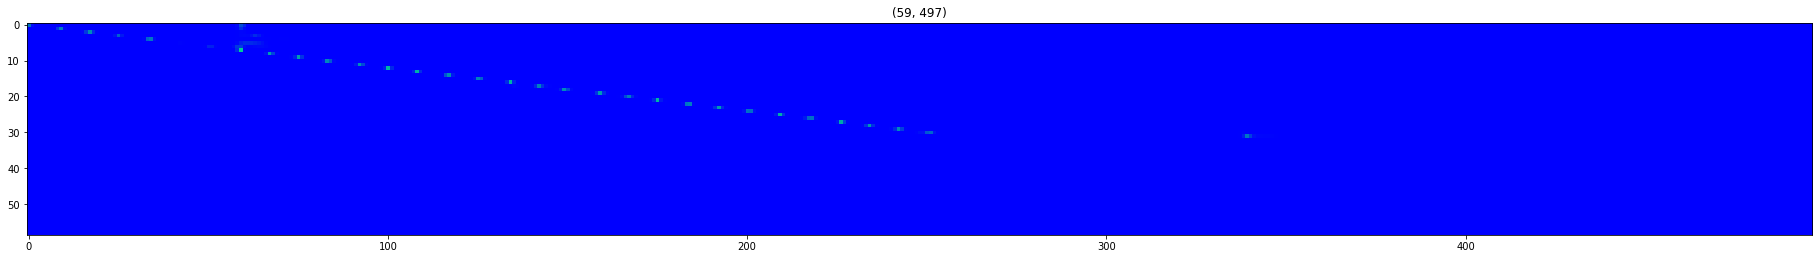

In [240]:
print(target)
ww = w[0].clone() * 1
# ww[:, 275:] = -999999999

# for i, t in enumerate(target[0]):
#     ww[i, t] = 1

print(cross(ww.unsqueeze(0).transpose(1, 2), (target + 0)))

show_tensor(ww)

torch.Size([2, 60, 497])


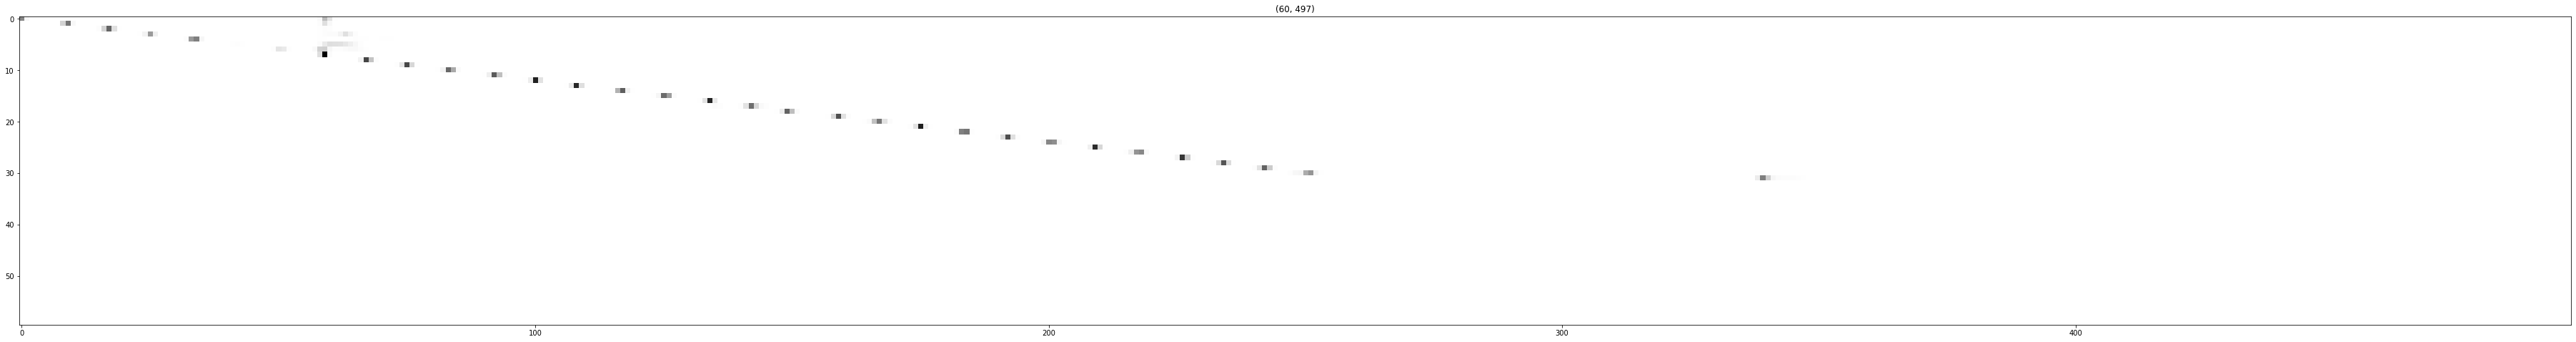

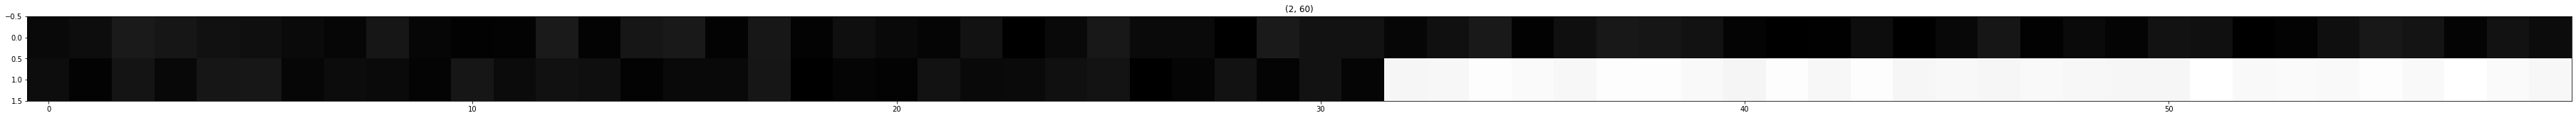

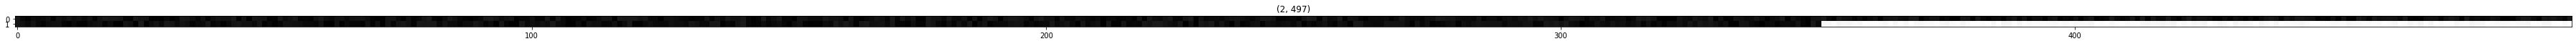

In [2]:
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
import torch

def show_tensor(aTensor, index=1, figsize=(64, 64), hide_x=False, labels=None, cmap=None, fig=True):
    # print(aTensor.shape, aTensor.sum())
    if len(aTensor.shape) > 2:
        aTensor = aTensor[index]

    if hasattr(aTensor, 'detach'): aTensor = aTensor.detach()
    if hasattr(aTensor, 'cpu'): aTensor = aTensor.cpu()
    if hasattr(aTensor, 'numpy'): aTensor = aTensor.numpy()

    fig and plt.figure(figsize=figsize)
    plt.title(str(aTensor.shape))
    plt.imshow(aTensor, cmap='Greys')
    plt.show()


mask_transcription = torch.load('mask_transcription.pt')  * 1.0
mask_audio = torch.load('mask_audio.pt') * 1.0
w = torch.load('w.pt')
r = torch.rand_like(w) * 0.1
w = w * mask_audio.unsqueeze(1) * mask_transcription.unsqueeze(2)
# w += r
print(w.shape)
show_tensor(w)
show_tensor(mask_transcription + torch.rand_like(mask_transcription) * 0.1)
show_tensor(mask_audio + torch.rand_like(mask_audio) * 0.1)
# print(mask_transcription)
# print(mask_audio)

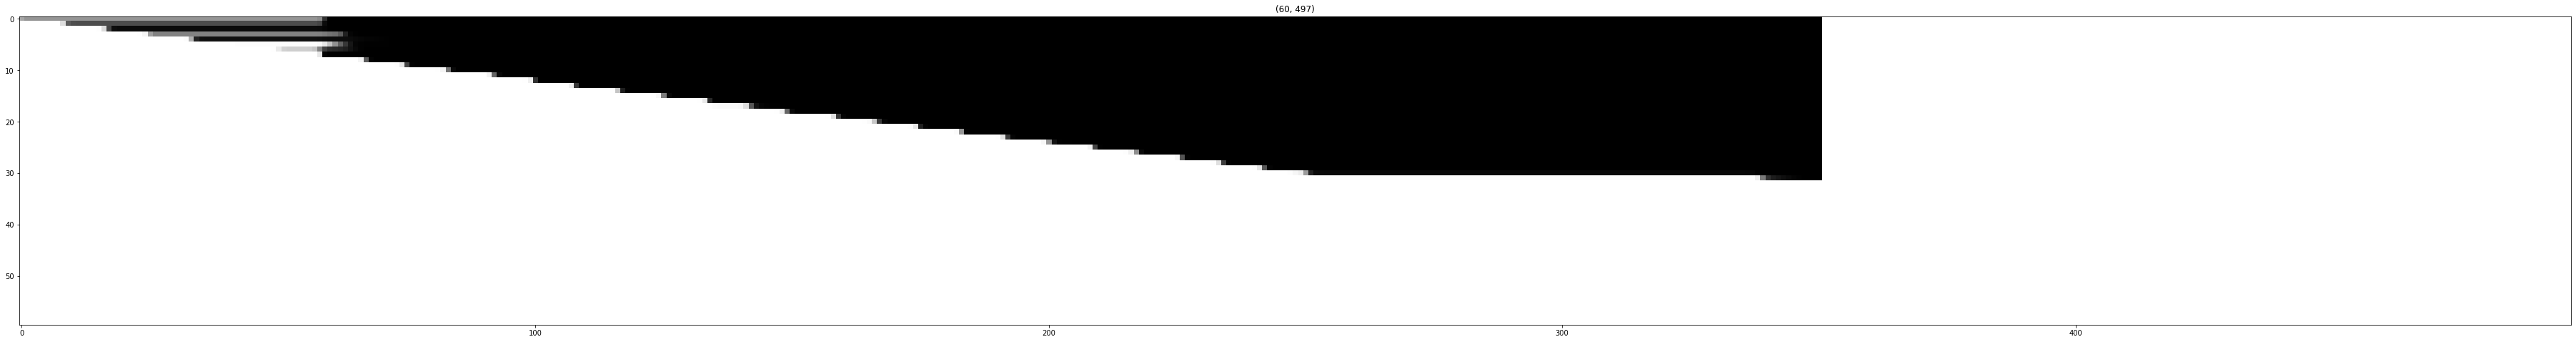

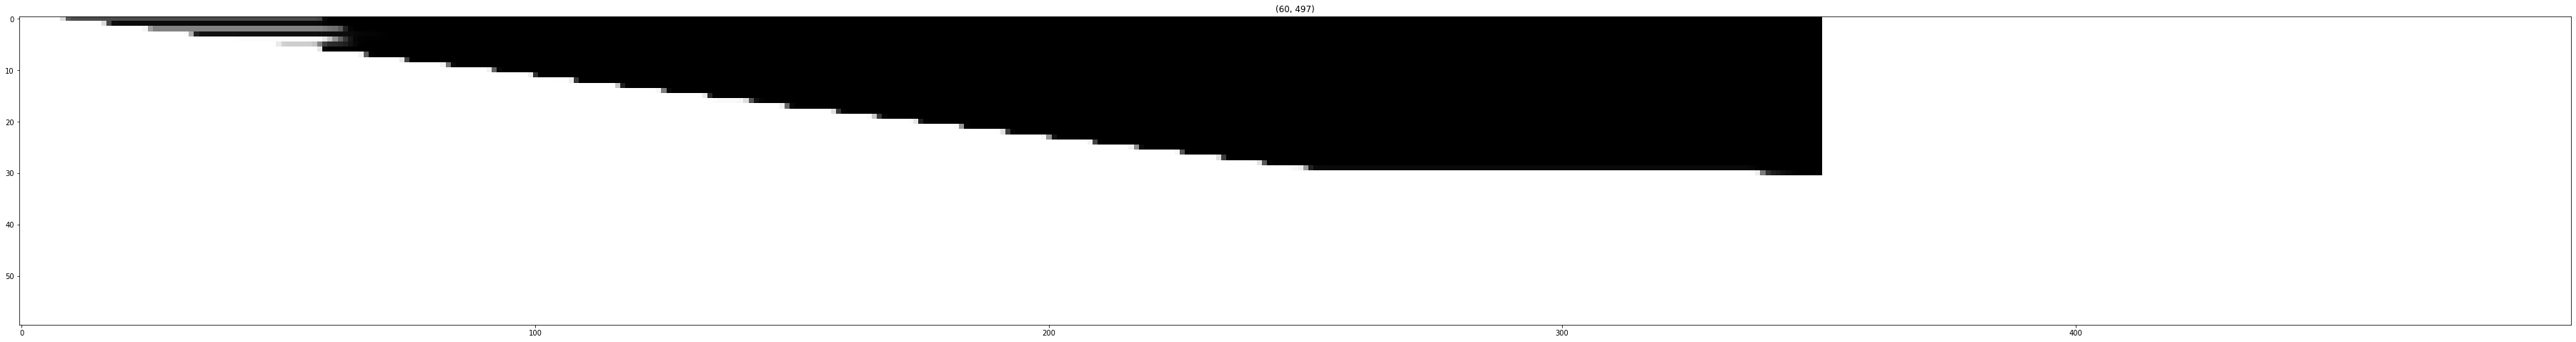

In [119]:
w_cum = torch.cumsum(w, dim=2) * mask_audio.unsqueeze(1)
show_tensor(w_cum)
show_tensor(torch.roll(w_cum, -1, 1) * mask_transcription.unsqueeze(2))

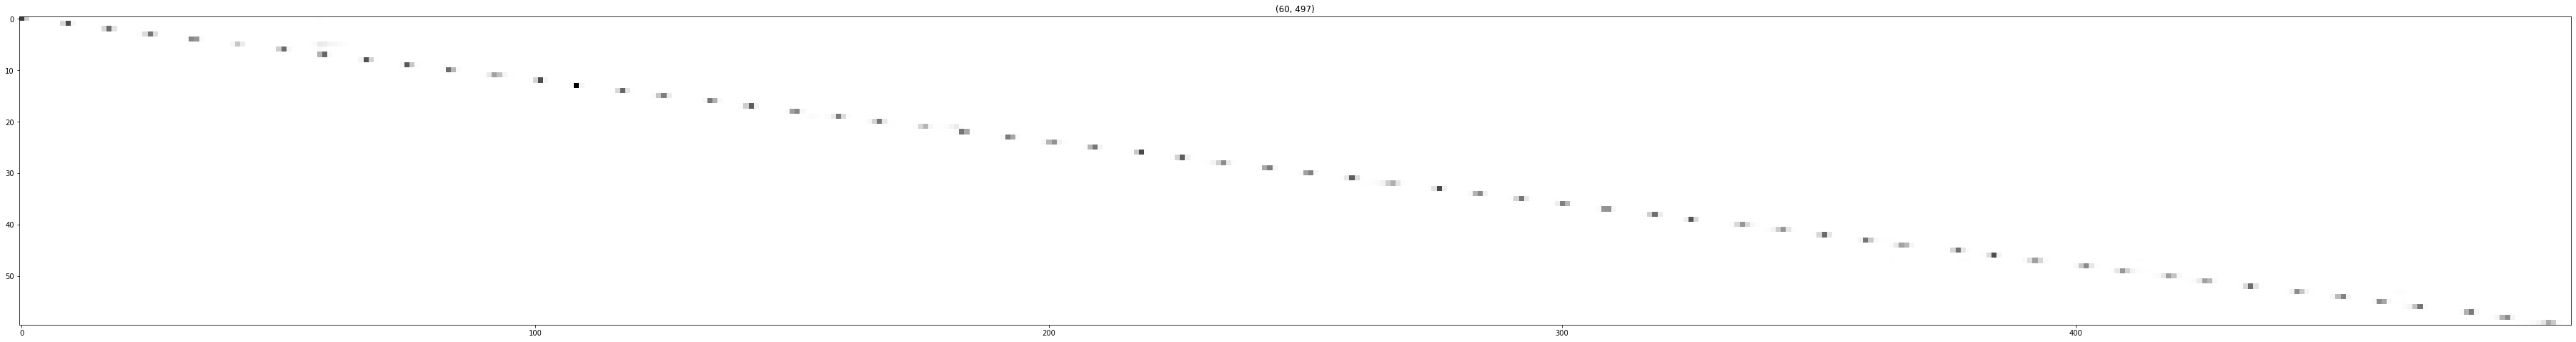

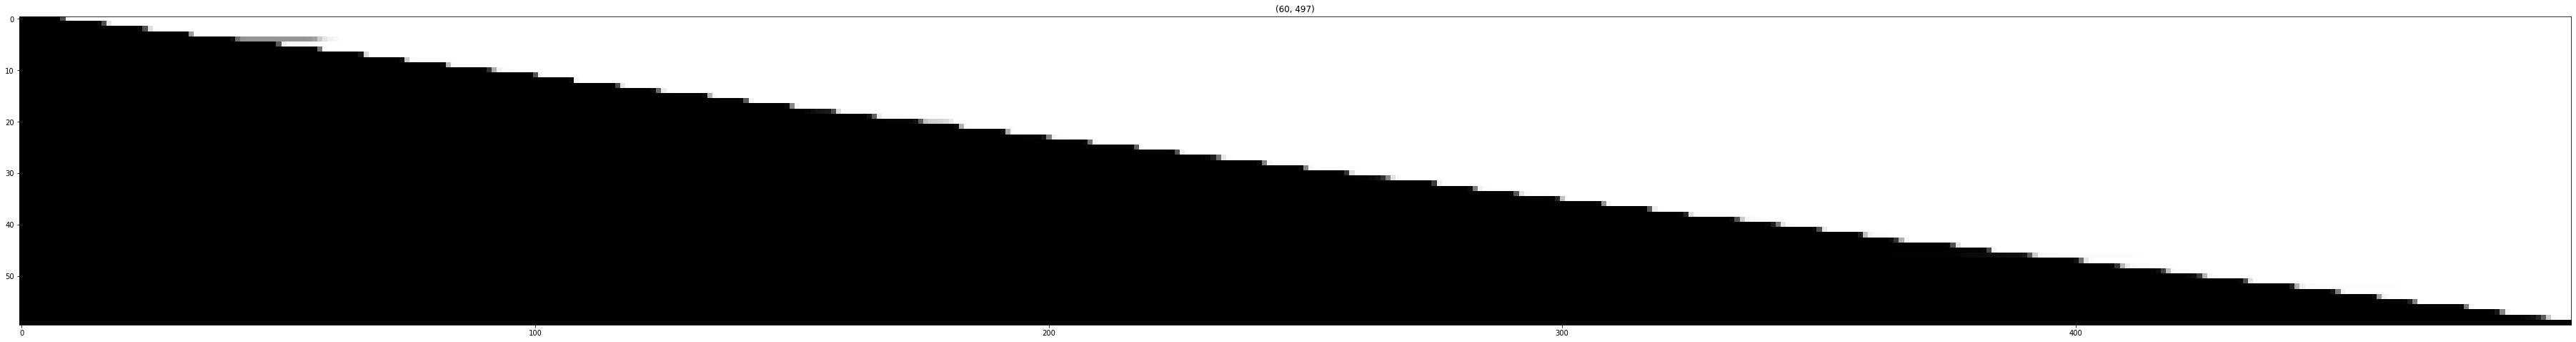

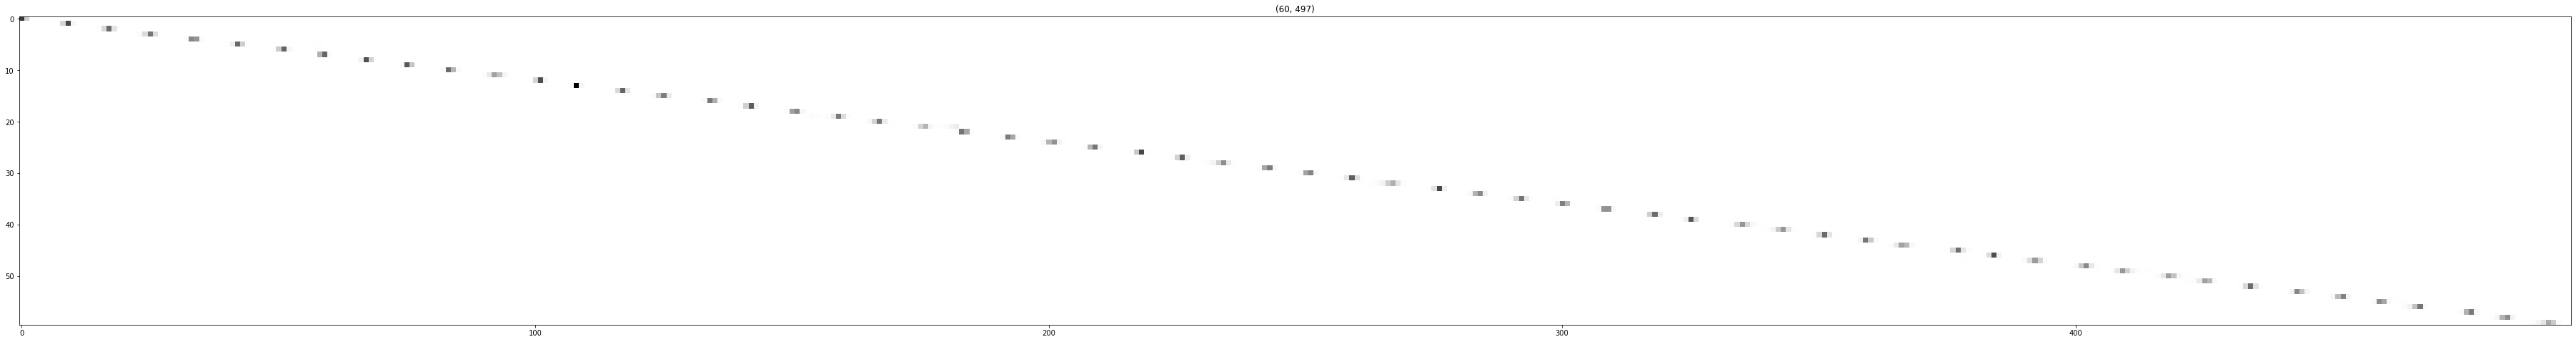

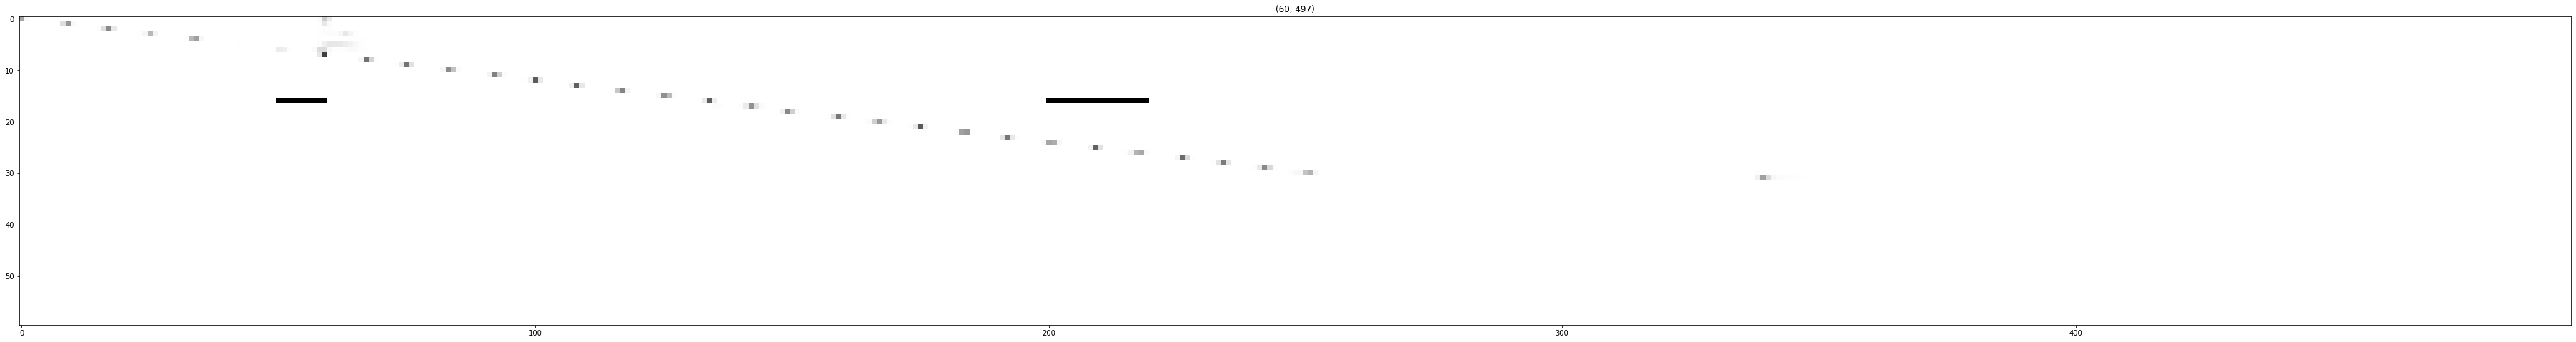

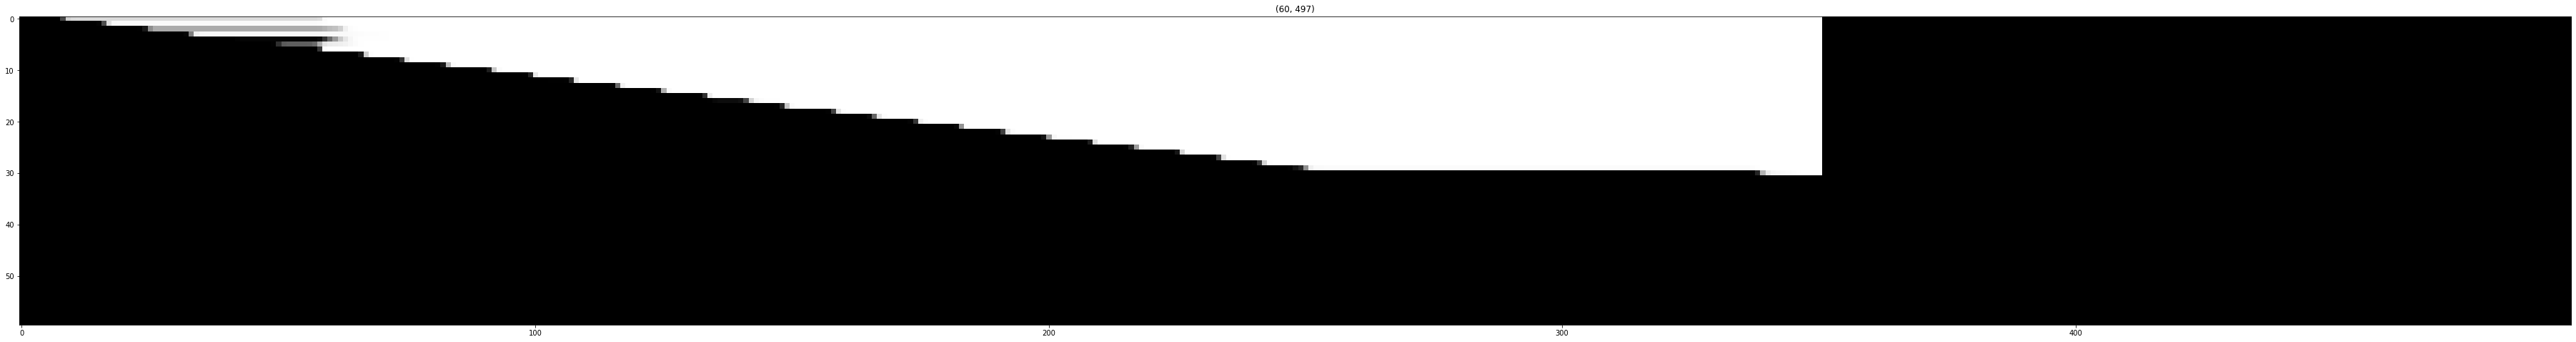

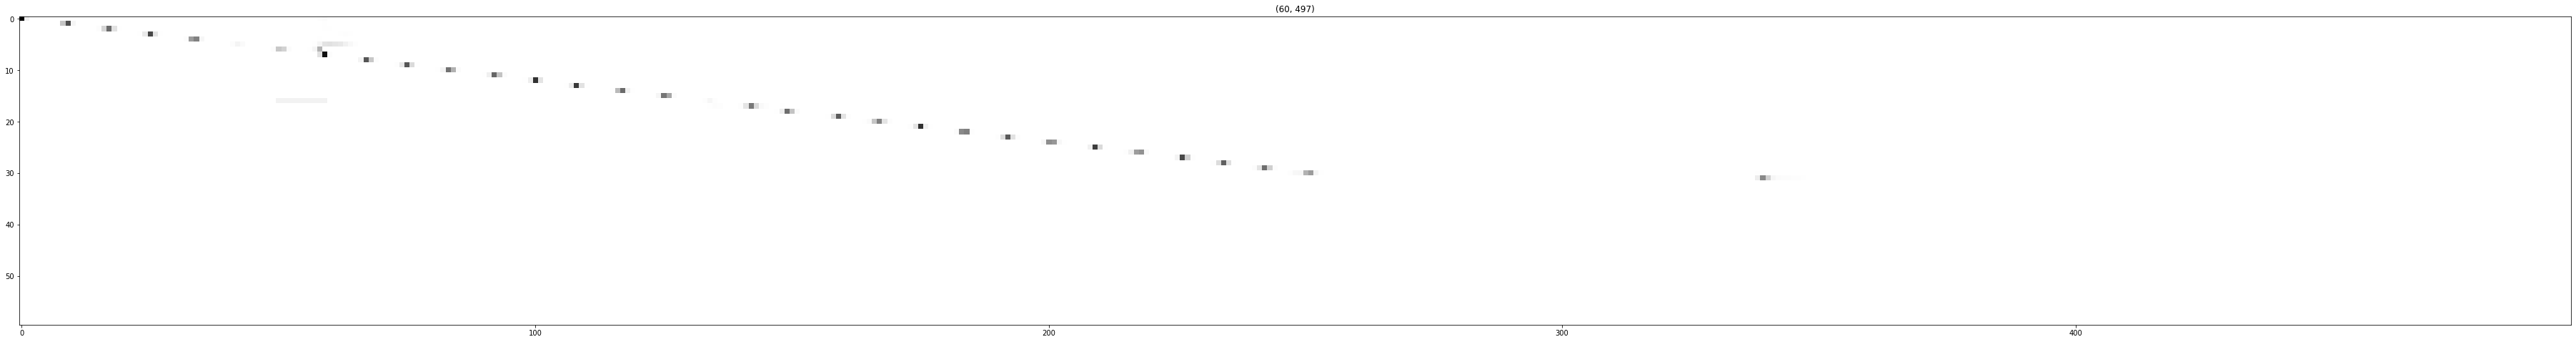

In [130]:
w_changed = w.clone()
w_changed[1, 16, 200: 220] = 1
w_changed[1, 16, 50: 60] = 1

mask = mask_transcription.clone()
mask[:, :-1] *= mask[:, 1:]
mask[:, -1] = False

w_cum_roll = 1 - torch.roll(w_cum, -1, 1) * mask.unsqueeze(2)
w_new = w_changed * w_cum_roll

w_new = torch.div(w_new, w_new.sum(dim=2).unsqueeze(2))
w_new = torch.nan_to_num(w_new)

for i in range(2):
    show_tensor(w_changed, index=i)
    show_tensor(w_cum_roll, index=i)
    show_tensor(w_new, index=i)

In [85]:
w_new.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])